In [1]:
import numpy as np
import time
import os
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import tensorflow as tf
import json
from urllib import request, parse

from PIL import Image
from matplotlib.patches import Ellipse, Circle
from sklearn.utils import shuffle
from tensorflow.python.platform import gfile


In [2]:
EYE_W = 80
EYE_H = 60
def getEye4Image(imageFilePath):
#     image = Image.open(imageFilePath)
    image  = cv2.imread(imageFilePath, cv2.IMREAD_COLOR)
    img = cv2.GaussianBlur(image, (5,5), 1.5);
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     img = cv2.cvtColor(np.asarray(image),cv2.COLOR_RGB2BGR)
    
    g = Image.fromarray(cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB))
    faceCascade = cv2.CascadeClassifier('../model/haarcascade_frontalface_default.xml')
    faces = faceCascade.detectMultiScale(image, 1.1,2, cv2.CASCADE_SCALE_IMAGE,minSize=(100,100))
    
    if len(faces) > 0:
        size = 0
        n = 0
        for i in range(len(faces)):
            if size < faces[i][2]:
                size = faces[i][2]
                n = i
        fx = faces[n][0]
        fy = faces[n][1]
        fw = faces[n][2]
        fh = faces[n][3]
        face = image[fy:fy+fh, fx:fx+fw]
        eyeCascade = cv2.CascadeClassifier('../model/haarcascade_lefteye_2splits.xml')
        eyes = eyeCascade.detectMultiScale(face, 1.2,2)
#         print('eye:',len(eyes))
        if len(eyes) > 0:
            lr = 1024
            for i in range(len(eyes)):
                if lr > eyes[i][0]:
                    lr = eyes[i][0]
                    n = i
            w = eyes[n][2]
            h = eyes[n][3]
            x = fx + eyes[n][0]
            y = fy + eyes[n][1] + h/4
            h = h*3/4
            print(x, y, w, h)
#             eye = g.crop((fx+x, fy+y, fx+x+w, fy+y+h))

        
#         w = w + (zoom[0]-EYE_W)
#         x = int(x + w/8) - (zoom[0]-EYE_W)/2
#         w = int(w - w/4)
#         h = h + (zoom[1]-EYE_H)
#         y = int(y + h/4) - (zoom[1]-EYE_H)/2
       
#         h = int(h/4)
#         eye = g.crop((x, y, x+w, y+h))
#         eye = eye.resize(zoom,Image.ANTIALIAS)

    eyeX = x
    eyeY = y
    
    eyeW = w
    eyeH = int(w*3/4.0)
    
    eyeBox = (eyeX, eyeY, eyeX+eyeW, eyeY+eyeH)

    eye = g.crop(eyeBox)
    eyeImage = eye.resize((EYE_W,EYE_H),Image.ANTIALIAS)
    eyeGray = eyeImage.convert('L')
    eyeData = np.array(eyeGray)
#     plt.figure(figsize=(6,2))
#     ax = plt.subplot(121)
#     plt.imshow(eyeImage)
#     plt.show()
    return eyeData,eyeImage,eyeX,eyeY,eyeW,eyeH

def getTestData(eye):
    data_list = []
    data = eye/255.0
    data_list.append(data)
    X = np.vstack(data_list)
    X = X.reshape(-1, EYE_W*EYE_H, 1)
    return X
    

In [3]:
def display(name):
    eyeData, eyeImage, eyeX, eyeY, eyeW, eyeH= getEye4Image(name)
    xyc = ['RAX','RAY','yellow',
          'ROX','ROY','red',
          'RBX','RBY','blue',
          'RUX','RUY','green',
          'RDX','RDY','aqua',
          
#           'LAX','LAY','yellow',
#           'LOX','LOY','red',
#           'LBX','LBY','blue',
#           'LUX','LUY','green',
#           'LDX','LDY','aqua'
    ]
    eye_label = []
    test_list = getTestData(eyeData)
    with tf.gfile.FastGFile('../data/eye_17000.pb', 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            tf.import_graph_def(graph_def, name='')
    with tf.Session() as sess:
        out_tensor_name = 'layer/out/p/output:0'
        out_data_tensor = sess.graph.get_tensor_by_name(out_tensor_name)
        batch_xs = test_list[0:1,...]
#         print(batch_xs.shape)
        batch_xs = batch_xs.reshape(-1, EYE_W*EYE_H)
        data_tensor = sess.run(out_data_tensor,{'input/x:0':batch_xs,'input/k:0':1.0})
#         print(data_tensor)
    plt.figure(figsize=(6,2))
    ax = plt.subplot(121)
    plt.imshow(eyeImage)
    for i in range(5):
        px = data_tensor[0][2*i]*EYE_W/2.0 + EYE_W/2.0 #flag[xyc[i*3]] - eyeX
        py = data_tensor[0][2*i+1]*EYE_W/2.0 + EYE_W/2.0 #flag[xyc[i*3+1]] - eyeY
        plt.plot(int(px), int(py), '.', label='point', color=xyc[i*3+2])
    plt.show()
    

268 214.5 66 49.5


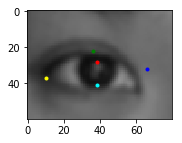

100 337.75 115 86.25


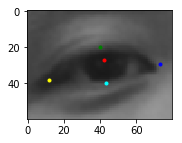

260 716.75 247 185.25


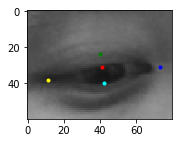

In [4]:
display('../data/003.jpg')
display('../data/test.001.jpg')
display('../data/test.002.jpg')

eye: 2
268 214.5 66 49.5


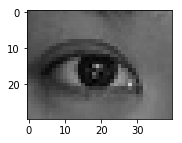

In [20]:
eyeData, eyeImage, eyeX, eyeY, eyeW, eyeH= getEye4Image('../data/003.jpg')
# eyeData, eyeImage, eyeX, eyeY, eyeW, eyeH= getEye4Image('../data/test.001.jpg')

(1, 1200, 1)
[[ 0.12625062  0.4892332   0.45934972  0.4502345   0.87446928  0.45759332
   0.46760964  0.31040502  0.47044989  0.54457533]]


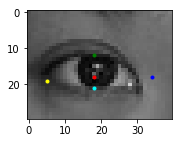

In [21]:

xyc = ['RAX','RAY','yellow',
          'ROX','ROY','red',
          'RBX','RBY','blue',
          'RUX','RUY','green',
          'RDX','RDY','aqua',
          
#           'LAX','LAY','yellow',
#           'LOX','LOY','red',
#           'LBX','LBY','blue',
#           'LUX','LUY','green',
#           'LDX','LDY','aqua'
    ]
eye_label = []

test_list = getTestData(eyeData)

with tf.gfile.FastGFile('../data/eye_4000.pb', 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name='')
with tf.Session() as sess:
    out_tensor_name = 'layer/out/p/output:0'
    out_data_tensor = sess.graph.get_tensor_by_name(out_tensor_name)
    batch_xs = test_list[0:1,...]
    print(batch_xs.shape)
    batch_xs = batch_xs.reshape(-1, EYE_W*EYE_H)
    data_tensor = sess.run(out_data_tensor,{'input/x:0':batch_xs,'input/k:0':1.0})
    print(data_tensor)
plt.figure(figsize=(6,2))
ax = plt.subplot(121)
plt.imshow(eyeImage)
for i in range(5):
#     px = data_tensor[0][2*i]
#     py = data_tensor[0][2*i+1]
#     plt.plot(int(px), int(py), '.', label='point', color=xyc[i*3+2])
    
    px = data_tensor[0][2*i]*EYE_W #flag[xyc[i*3]] - eyeX
    py = data_tensor[0][2*i+1]*EYE_W #flag[xyc[i*3+1]] - eyeY
#     px = px*eyeW/EYE_W
#     py = py*eyeH/EYE_H
    plt.plot(int(px), int(py), '.', label='point', color=xyc[i*3+2])
    
plt.show()
#     for i in range(10):
#         predictions = np.squeeze(data_tensor[i])
#         top_k = predictions.argsort()[-1:][::-1]
#         for node_id in top_k:     
#             score = predictions[node_id]
#             num_label.append(node_id)

In [30]:
import Number as num
import time
for i in range(50):
    t1 = time.clock()
    n = num.getNum('images/00.png')
    t2 = time.clock()
    print("%f"%((t2-t1)))
num.display('images/00.png')



ModuleNotFoundError: No module named 'Number'

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from tensorflow.python.platform import gfile
#from tensorflow.python.framework import graph_util
from PIL import Image

import time

sess = None
w = 60#360
h = 80#178
ws = 150
hs = 52
box0  = [
    [ws,hs+1353, w, h],
    [ws,hs+1531, w, h],
    [ws,hs+1711, w, h],
#     [ws,hs+1888, w, h],
    
    [ws+361,hs+1353, w, h],
    [ws+361,hs+1531, w, h],
    [ws+361,hs+1711, w, h],
    [ws+361,hs+1888, w, h],
    
    [ws+721,hs+1353, w, h],
    [ws+721,hs+1531, w, h],
    [ws+721,hs+1711, w, h],
#     [ws+721,hs+1888, w, h],
]
box  = [
    [ws,hs+1408, w, h],
    [ws,hs+1597, w, h],
    [ws,hs+1784, w, h],
#     [ws,hs+1971, w, h],
    
    [ws+361,hs+1408, w, h],
    [ws+361,hs+1597, w, h],
    [ws+361,hs+1784, w, h],
    [ws+361,hs+1971, w, h],
    
    [ws+721,hs+1408, w, h],
    [ws+721,hs+1597, w, h],
    [ws+721,hs+1784, w, h],
#     [ws+721,hs+1971, w, h],
]

In [2]:
def get_image(filename):
    img = np.array(Image.open(filename).convert('L'),'f')
    ss = img.reshape(-1, w*h)
    return ss

In [3]:
def getNumImg(name):
    img = Image.open(name)
    data_list = []
    for i in range(len(box)):
        b = (box[i][0], box[i][1], box[i][0]+box[i][2], box[i][1]+box[i][3])
        roi = img.crop(b)
#         print(type(roi))
        roi.save('tmp.png')
        d = get_image('tmp.png')
        d = d/255.0
#         tf.cast(d, tf.float32)
        ss = d.reshape(w*h,1)
#         image_val = tf.concat(0,ss)
        data_list.append(ss)
    X = np.vstack(data_list)
    X = X.reshape(-1, w*h, 1)
    
    return X
    
def display(name):
    img = Image.open(name)

    box = (0, 1080, 1330, 2160)
    roi = img.crop(box)
#     sq = img.shape[0]
#     print("sq:%s %s" % (sq, img.shape))
    
#     one_image = img.reshape(int(sq), int(sq))   
    plt.axis('off')                         
    plt.imshow(roi)
    plt.show()
    
def getNum(fileName):
    
    test_list = getNumImg(fileName)
    name_str = [
        '数字0',
        '数字1',
        '数字2',
        '数字3',
        '数字4',
        '数字5',
        '数字6',
        '数字7',
        '数字8',
        '数字9',
        ]
    num_label = []
    with tf.gfile.FastGFile('./num.pb', 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            tf.import_graph_def(graph_def, name='')
    with tf.Session() as sess:
        out_tensor_name = 'layer/out/p/output:0'
        out_data_tensor = sess.graph.get_tensor_by_name(out_tensor_name)
        batch_xs = test_list[0:10,...]
        batch_xs = batch_xs.reshape(-1, w*h)
        data_tensor = sess.run(out_data_tensor,{'input/x:0':batch_xs,'input/k:0':1.0})
        for i in range(10):
            predictions = np.squeeze(data_tensor[i])
            top_k = predictions.argsort()[-1:][::-1]
            for node_id in top_k:     
                score = predictions[node_id]
                num_label.append(node_id)
        #         print(score)
                #print('位置 %s %s (识别概率：%.5f)' % (i,name_str[int(node_id)], score))
#             print()
    return num_label

0.143999
[5, 9, 0, 1, 7, 3, 2, 6, 8, 4]
0.144046
[5, 9, 0, 1, 7, 3, 2, 6, 8, 4]
0.159934
[5, 9, 0, 1, 7, 3, 2, 6, 8, 4]
0.168760
[5, 9, 0, 1, 7, 3, 2, 6, 8, 4]
0.189121
[5, 9, 0, 1, 7, 3, 2, 6, 8, 4]
0.190269
[5, 9, 0, 1, 7, 3, 2, 6, 8, 4]
0.247214
[5, 9, 0, 1, 7, 3, 2, 6, 8, 4]
0.210766
[5, 9, 0, 1, 7, 3, 2, 6, 8, 4]
0.220305
[5, 9, 0, 1, 7, 3, 2, 6, 8, 4]
0.230701
[5, 9, 0, 1, 7, 3, 2, 6, 8, 4]
0.239255
[5, 9, 0, 1, 7, 3, 2, 6, 8, 4]
0.252198
[5, 9, 0, 1, 7, 3, 2, 6, 8, 4]
0.262865
[5, 9, 0, 1, 7, 3, 2, 6, 8, 4]
0.322244
[5, 9, 0, 1, 7, 3, 2, 6, 8, 4]
0.286396
[5, 9, 0, 1, 7, 3, 2, 6, 8, 4]
0.289285
[5, 9, 0, 1, 7, 3, 2, 6, 8, 4]
0.299598
[5, 9, 0, 1, 7, 3, 2, 6, 8, 4]
0.322056
[5, 9, 0, 1, 7, 3, 2, 6, 8, 4]
0.391219
[5, 9, 0, 1, 7, 3, 2, 6, 8, 4]
0.356520
[5, 9, 0, 1, 7, 3, 2, 6, 8, 4]
0.350637
[5, 9, 0, 1, 7, 3, 2, 6, 8, 4]
0.369298
[5, 9, 0, 1, 7, 3, 2, 6, 8, 4]
0.392616
[5, 9, 0, 1, 7, 3, 2, 6, 8, 4]
0.427320
[5, 9, 0, 1, 7, 3, 2, 6, 8, 4]
0.395221
[5, 9, 0, 1, 7, 3, 2, 6, 8, 4]


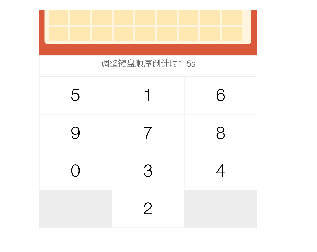

In [5]:
for i in range(50):
    t1 = time.clock()
    n = getNum('images/00.png')
    t2 = time.clock()
    print("%f"%((t2-t1)))
    print(n)
display('images/00.png')